# Content
- One-way ANOVA (significant difference among three or more means?)
- Scheffé test and Tukey test (which means differ? only if H0 rejected int ANOVA)
- Two-way ANOVA (significant difference in the main effects or interaction?)

In [253]:
# Imports
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
MultiComparison
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import numpy as np
import pandas as pd
import math
import pylab
import seaborn as sns
import os

# Constants
INPUT_DIR = r'Input Data'

# One-way ANOVA

## Goal

We want to find out if there is a significant difference in 3 or more means and which means differ.

**Even though we are comparing means, the F test uses variances instead of means!**

It is a one-way ANOVA because we only focus on one variable.

## Notes

The F test used for ANOVA can only tell if there is a difference between the means, but NOT which means are different.

It would be possible to use the F test for comparing 2 means, however the result would be the same as with the t test.
Reasons for not using t test or z test for comparing more than 2 means:
1. If comparing only 2 means at the time, other means are ignored
2. Probability of rejecting H0 when true (type I error) increases since the more t test conducted, the greater the likelihood of getting significant differences due to chance.
3. The more means to compare, the more t tests needed (3 means -> 3 tests, 5 means -> 10 tests, 10 means -> 45 tests).

## Applications

We can use one-way ANOVA (and the F test) to know if the mean time to solve a problem is different if students use Java, C++ or Python. Here the variable is called "programming language".

## Assumptions

1. Populations of the samples must be normally distributed.
2. Samples must be independent (chi-square test for independency)
3. Population variances must be equal

## F test

### Logic
The idea is to estimate **between-group variance** (which involves finding the variance of the means) and then the **within-group variance**, by using all data.

If there is no difference in the means, then both variances will be approximately equal and the F test close to 1.

### Hypothesis

H0: all means are equal.

H1: at least 1 mean is different from the others.

### Degrees of freedom

d.f.N. = k-1 (k = number of groups)

d.f.D. = N-k (N = sum of samples sizes of groups)

### Critical values
We always do a right-tailed test.

### Implementation

In [130]:
def compute_one_way_anova(
    df,
    dependent_variable_array, # assuming sorting is in-line with group_variable_array
    group_variable_array,
    alpha=0.05,
):
    
    # Convert df columns into lists
#     k = len(df.columns) # number of groups
    group_list = group_variable_array.unique()
    k = len(group_list) # number of groups
    N = 0
    anova_datasets = list()
#     for c in list(df):
#         c_list = df[c].tolist()
#         N += len(c_list)
#         anova_datasets.append(c_list)
    
    # Get variable names
    group_variable_name = group_variable_array.name
    dependent_variable_name = dependent_variable_array.name
   
    # Prepare data in right format for ANOVA function
    for group in group_list:
        c_list = df.loc[df[group_variable_name] == group][dependent_variable_name].values.tolist()
        N += len(c_list)
        anova_datasets.append(c_list)
    
    # Get statistical values
    stat, p = stats.f_oneway(*anova_datasets)
    
    dfN = k-1
    dfD = N-k
    print('dfN=', dfN)
    print('dfD=', dfD)
    
    print('H0: all means are the same.')
    print('H1: at least 1 mean is different from the others.')
    reject_label = 'Result: at least 1 mean is different from the others (enough evidence to reject H0)'
    not_reject_label = 'Result: all means are the same (fail to reject H0)'
    
    # interpret test-statistic
    prob = 1-alpha
    critical = stats.f.ppf(q=prob, dfn=dfN, dfd=dfD)
    print('Traditional method')
    print('probability=%.2f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print(reject_label)
    else:
        print(not_reject_label)
    
    # interpret p-value
    print()
    print('p-value method')
    print('significance=%.2f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print(reject_label)
    else:
        print(not_reject_label)

### Exercises

In [131]:
# Check if difference in mean among 3 techniques to lower blood pressure

# This format is unusual
# df_blood_pressure_textbook_format = pd.DataFrame({
#     'medication': [10, 12, 9, 15, 13],
#     'exercise': [6, 8, 3, 0, 2],
#     'diet': [5, 9, 12, 8, 4],
# })

# Usual format for analysis
df_blood_pressure = pd.DataFrame({
    'technique': [
        'medication', 'medication', 'medication', 'medication', 'medication',
        'exercise', 'exercise', 'exercise', 'exercise', 'exercise',
        'diet', 'diet', 'diet', 'diet', 'diet',
    ],
    'blood_pressure': [
        10, 12, 9, 15, 13,
        6, 8, 3, 0, 2,
        5, 9, 12, 8, 4,
    ],
})

compute_one_way_anova(
    df_blood_pressure,
    df_blood_pressure['blood_pressure'], 
    df_blood_pressure['technique'],
    alpha=0.05,
)

dfN= 2
dfD= 12
H0: all means are the same.
H1: at least 1 mean is different from the others.
Traditional method
probability=0.95, critical=3.885, stat=9.168
Result: at least 1 mean is different from the others (enough evidence to reject H0)

p-value method
significance=0.05, p=0.004
Result: at least 1 mean is different from the others (enough evidence to reject H0)


In [133]:
# Check if difference in mean among number of employees at toll roads

# This format is unusual
# df_toll_roads = pd.DataFrame({
#     'pennsylvannia': [7, 14, 32, 19, 10, 11],
#     'greensburg': [10, 1, 1, 0, 11, 1],
#     'valley': [1, 12, 1, 9, 1 ,11],
# })

# Usual format for analysis
df_toll_roads = pd.DataFrame({
    'region': [
        'pennsylvannia', 'pennsylvannia', 'pennsylvannia', 'pennsylvannia', 'pennsylvannia', 'pennsylvannia',
        'greensburg', 'greensburg', 'greensburg', 'greensburg', 'greensburg', 'greensburg',
        'valley', 'valley', 'valley', 'valley', 'valley', 'valley',
    ],
    'employee_number': [
        7, 14, 32, 19, 10, 11,
        10, 1, 1, 0, 11, 1,
        1, 12, 1, 9, 1 ,11,
    ],
})

compute_one_way_anova(
    df_toll_roads,
    df_toll_roads['employee_number'], 
    df_toll_roads['region'],
    alpha=0.05,
)

dfN= 2
dfD= 15
H0: all means are the same.
H1: at least 1 mean is different from the others.
Traditional method
probability=0.95, critical=3.682, stat=5.035
Result: at least 1 mean is different from the others (enough evidence to reject H0)

p-value method
significance=0.05, p=0.021
Result: at least 1 mean is different from the others (enough evidence to reject H0)


# Scheffé test and Tukey test

## Goal

If the ANOVA H0 is rejected (i.e. at least 1 mean is different from the others), then we want to know where the difference lies.

The Scheffé test and Tukey test are the most commonly used post-hoc tests.

## Scheffé test

### Definition

Pairwise comparison of means using all possible comparison.

**General test** that does not require the sample sizes to be equal.

### Formula

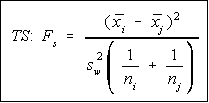

Critical value = F' = (k-1)(C.V.)

We can conclude a significant difference between the 2 means compared if FS > F'.

## Tukey test

### Definition

Pairwise comparison of means using all possible comparison.

**More powerful test** that requires same sample size.

Test also called **Tukey HSD**.

### Formula

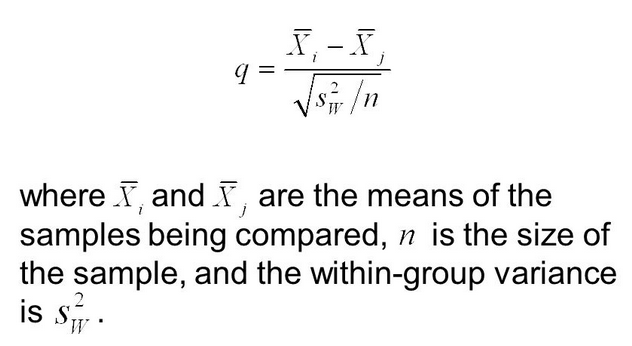

We can conclude a significant difference between the 2 means compared if |q| > C.V.

## Implementation

We use Scheffe if sample sizes are different, otherwise Tukey.

In [97]:
def compute_anova_posthoc_test(
    dependent_variable_array,
    group_variable_array,
    alpha=0.05,
):
    # Careful to put numeric variable first arg, then categorical second arg
    statistic_test = pairwise_tukeyhsd(dependent_variable_array, group_variable_array, alpha=alpha)
    print(statistic_test)

## Exercises

In [98]:
# Check if difference in mean among 3 techniques to lower blood pressure

# df in format as if loaded from CSV table
df_blood_pressure = pd.DataFrame({
    'technique': [
        'medication', 'medication', 'medication', 'medication', 'medication',
        'exercise', 'exercise', 'exercise', 'exercise', 'exercise',
        'diet', 'diet', 'diet', 'diet', 'diet',
    ],
    'blood_pressure': [
        10, 12, 9, 15, 13,
        6, 8, 3, 0, 2,
        5, 9, 12, 8, 4,
    ],
})

compute_anova_posthoc_test(
    df_blood_pressure['blood_pressure'], 
    df_blood_pressure['technique'],
    alpha=0.05,
)

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1    group2   meandiff  lower   upper  reject
---------------------------------------------------
  diet    exercise    -3.8   -8.7839  1.1839 False 
  diet   medication   4.2    -0.7839  9.1839 False 
exercise medication   8.0     3.0161 12.9839  True 
---------------------------------------------------


In [134]:
# Check if difference in mean among number of employees at toll roads
df_toll_roads = pd.DataFrame({
    'region': [
        'pennsylvannia', 'pennsylvannia', 'pennsylvannia', 'pennsylvannia', 'pennsylvannia', 'pennsylvannia',
        'greensburg', 'greensburg', 'greensburg', 'greensburg', 'greensburg', 'greensburg',
        'valley', 'valley', 'valley', 'valley', 'valley', 'valley',
    ],
    'employee_number': [
        7, 14, 32, 19, 10, 11,
        10, 1, 1, 0, 11, 1,
        1, 12, 1, 9, 1 ,11,
    ],
})

compute_anova_posthoc_test(
    df_toll_roads['employee_number'], 
    df_toll_roads['region'],
)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1        group2    meandiff  lower    upper  reject
------------------------------------------------------------
  greensburg  pennsylvannia   11.5    1.3895  21.6105  True 
  greensburg      valley     1.8333  -8.2772  11.9438 False 
pennsylvannia     valley    -9.6667  -19.7772  0.4438 False 
------------------------------------------------------------


# Two-way ANOVA

One-way ANOVA = 1 independent variable.

Two-way ANOVA = 2 independent variables.

**Independent variables are called factors**.


## Goal

The two-way ANOVA compares the mean differences between groups that have been split on two independent variables. 
The **primary purpose of a two-way ANOVA is to understand if there is an interaction between the two independent variables on the dependent variable**. For example, we could use a two-way ANOVA to understand whether there is an interaction between gender and educational level on test anxiety amongst university students, where gender (males/females) and education level (undergraduate/postgraduate) are the independent variables, and test anxiety is the dependent variable.

The **interaction term informs whether the effect of one of the independent variables on the dependent variable is the same for all values of your other independent variable (and vice versa)**. For example, is the effect of gender (male/female) on test anxiety influenced by educational level (undergraduate/postgraduate)? 

Additionally, if a statistically significant interaction is found, we need to determine whether there are any **main effects** (between independent variables), and if there are, what these effects are.


## Application

Test effect of 2 types of food (factor) and 2 types of fitness programs (factor) on physical condition index (dependent variable). Other factors such as average sleeping hours are held constant.

In [136]:
#         | Program I | Program II
# ----------------------------------
# Food A1 | A1,I      | A1,II
# Food A2 | A2,I      | A2,II
# ----------------------------------
# Two-by-two ANOVA

The design would be a 2X2 resulting in 4 **treatment groups** (i.e. 4 cells) in which each factor has 2 levels (i.e. 2 different treatments).

Now we can test the effect of interaction between 2 variables. For example, is there a difference between physical condition index with treatment group A1,I and physical condition index with treatment group A1,II?

**If yes**, then experiment has significant effect.

## Design

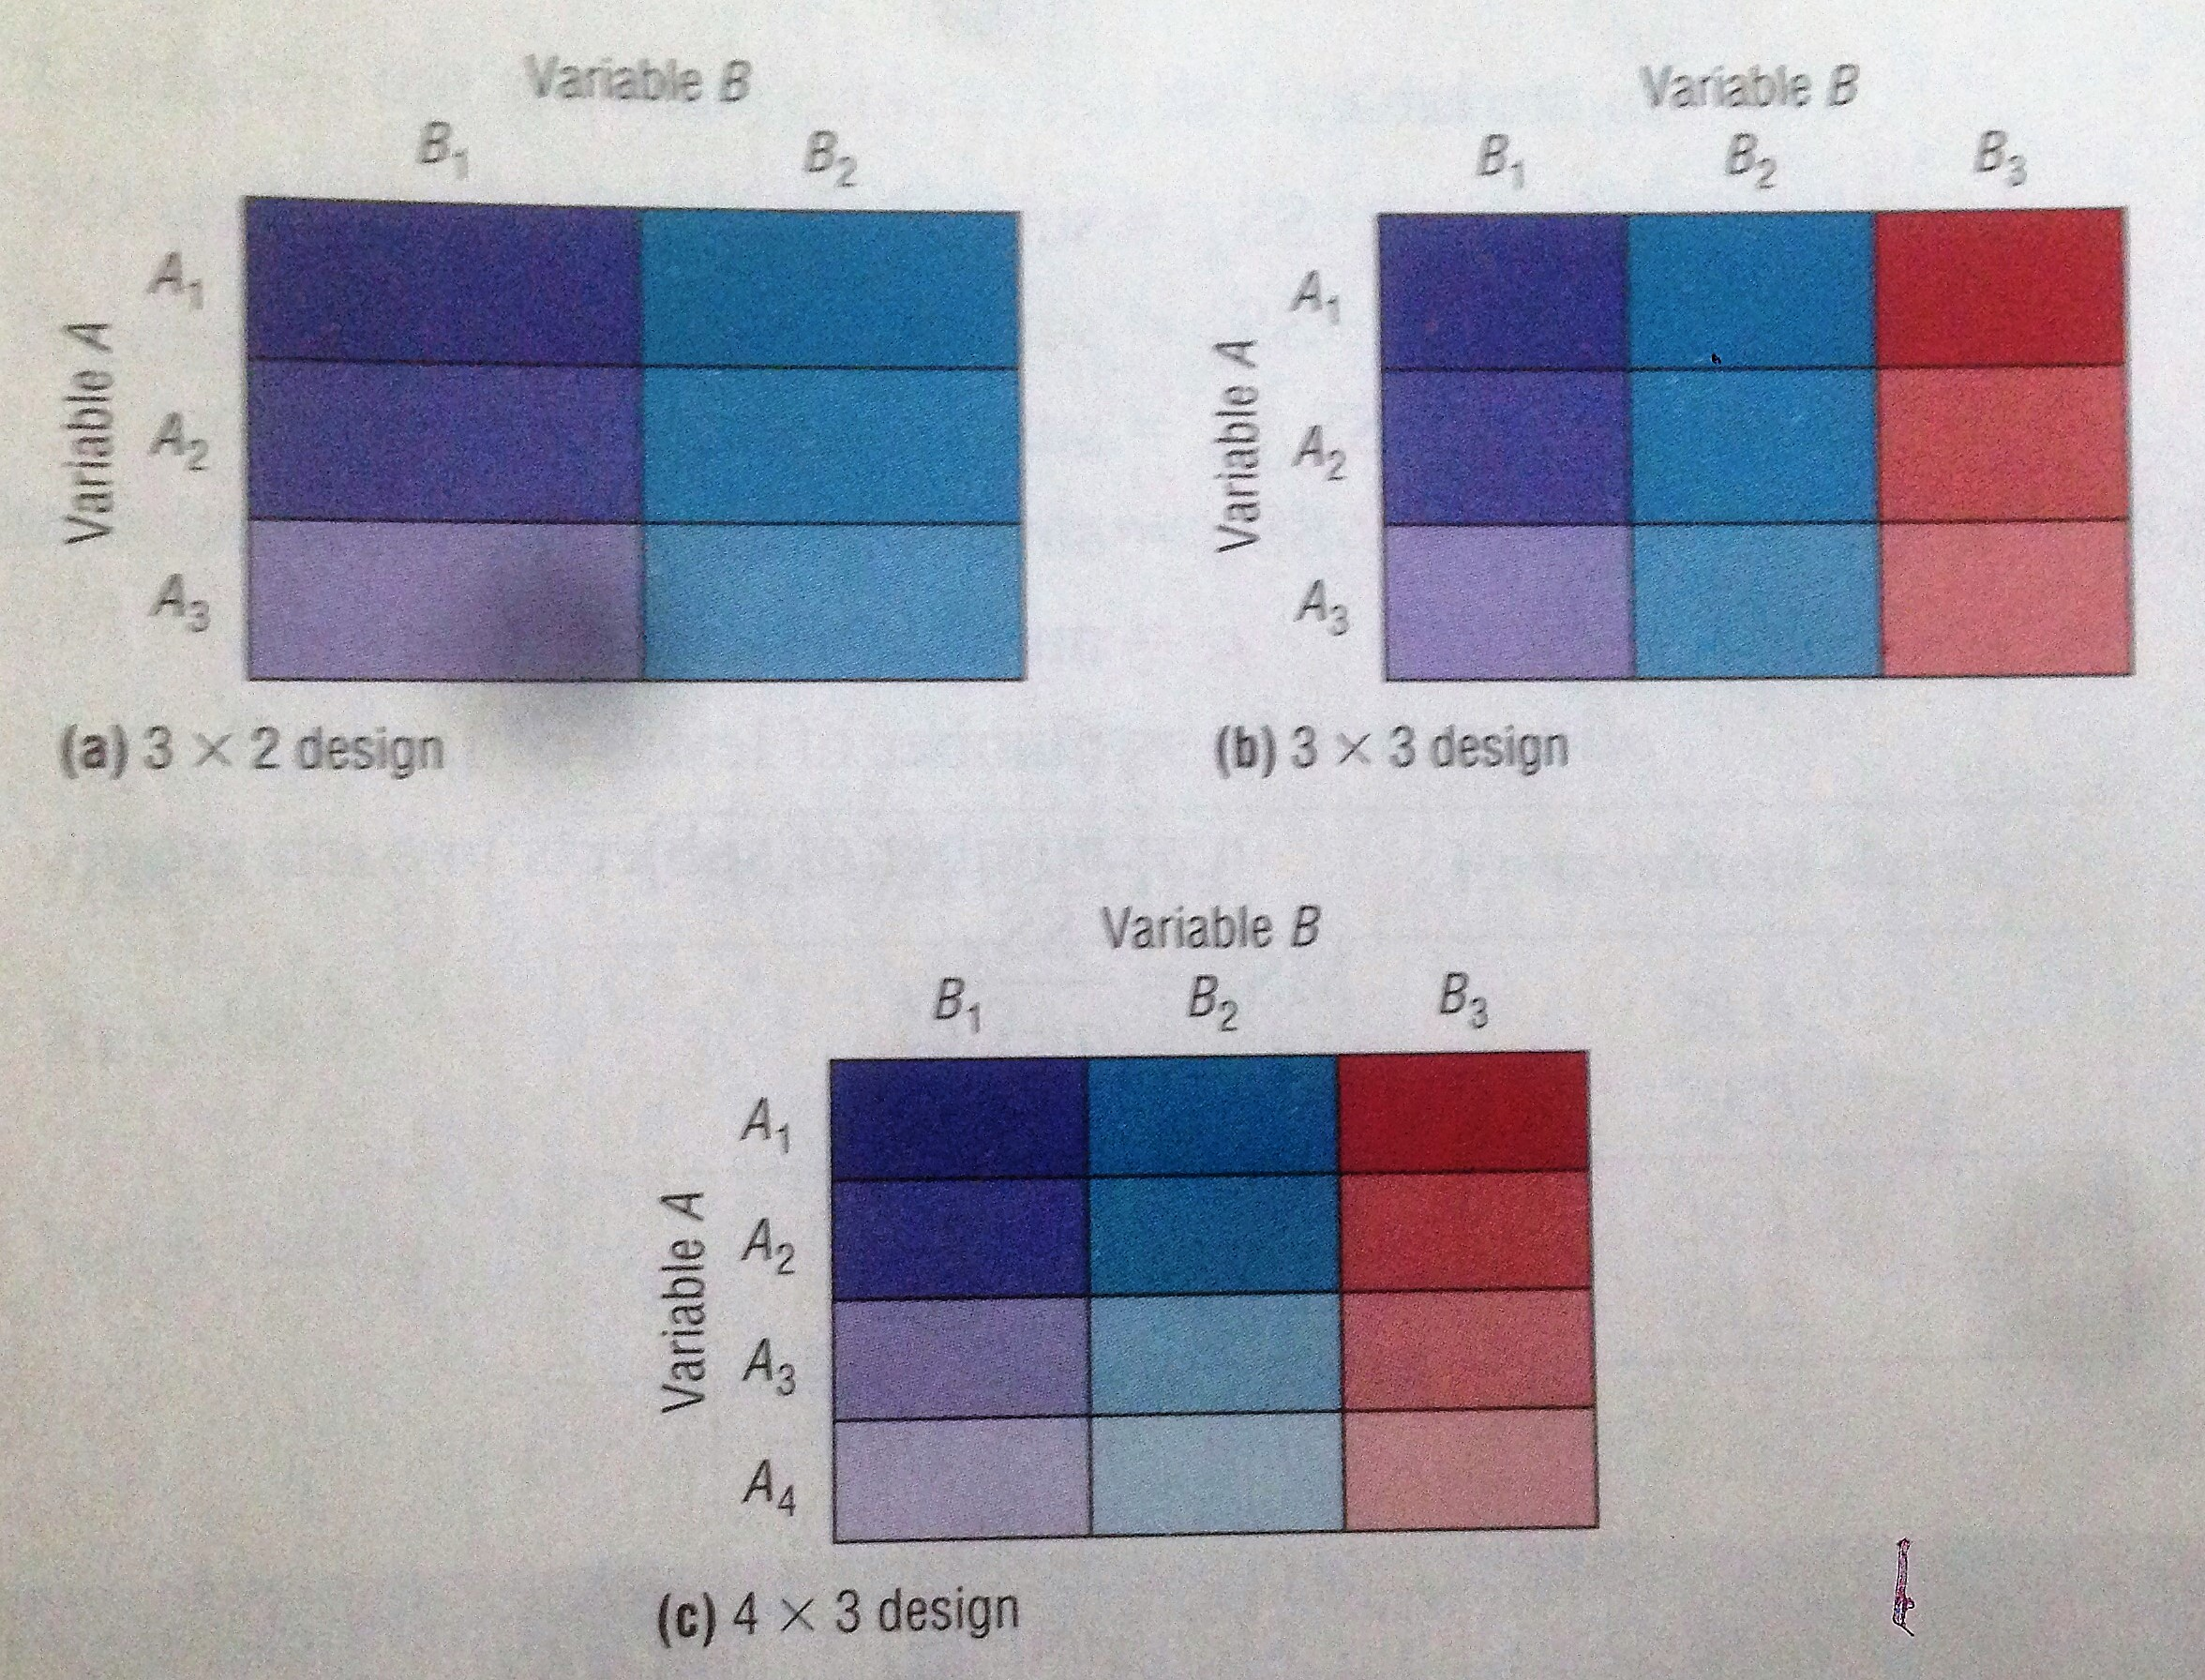

The design depends on the number of groups (i.e. distinctive values) of each factor.

## Hypothesis

Two-way ANOVA design has several hypotheses.
1. Hypotheses for testing interaction effect between factors
    - H0: no interaction effect between factor A and B
    - H1: significant interaction effect between factor A and B
2. Hypotheses for testing interaction effect of each factor on dependent variable (i.e. **main effects**)
    - H0: no difference between the mean of dependent variable for factor A group I and II.
    - H1: significant difference between the mean of dependent variable for factor A group I and II.
    
## Assumptions
1. Sample populations must be normally distributed
2. Samples must be independent
3. Variances of sample populations must be equal (cannot check easily so just assume).
4. Groups must be equal in sample size


## Implementation

In [288]:
def compute_two_way_anova(
    df,
    dependent_variable_name,
    independent_variable1_name,
    independent_variable2_name,
    alpha=0.05,
    display_chart=False,
    chart_color_list=['red','blue'],
):
    data = None
   
    if display_chart:        
        
        # Visualize factorial data
        fig = interaction_plot(
            df[independent_variable2_name], 
            df[independent_variable1_name], 
            df[dependent_variable_name],
            colors=chart_color_list,
            ms=10
        )
        plt.show()
    
    # Calculate degress of freedom
    N = len(df[dependent_variable_name])
    df_a = len(df[independent_variable1_name].unique()) - 1
    df_b = len(df[independent_variable2_name].unique()) - 1
    df_axb = df_a*df_b 
    df_w = N - (len(df[independent_variable1_name].unique())*len(df[independent_variable2_name].unique()))

    # Calculate sum of squares
    grand_mean = df[dependent_variable_name].mean()
    ssq_a = sum([(df[df[independent_variable1_name] ==l][dependent_variable_name].mean()-grand_mean)**2 for l in df[independent_variable1_name]])
    ssq_b = sum([(df[df[independent_variable2_name] ==l][dependent_variable_name].mean()-grand_mean)**2 for l in df[independent_variable2_name]])
    ssq_t = sum((df[dependent_variable_name] - grand_mean)**2)

    # Sum of Squares Within (error/residual)
    ssq_w = 0
    for category_name in df[independent_variable1_name].unique():        
        category_df = df[df[independent_variable1_name] == category_name]    
        category_means = [category_df[category_df[independent_variable2_name] == d][dependent_variable_name].mean() for d in category_df[independent_variable2_name]]
        ssq_w += sum((category_df[dependent_variable_name] - category_means)**2)

    # Sum of Squares for the interaction of A and B
    ssq_axb = ssq_t-ssq_a-ssq_b-ssq_w

    # Mean Squares
    ms_a = ssq_a/df_a
    ms_b = ssq_b/df_b
    ms_axb = ssq_axb/df_axb
    ms_w = ssq_w/df_w

    # F-ratio
    f_a = ms_a/ms_w
    f_b = ms_b/ms_w
    f_axb = ms_axb/ms_w

    # Obtaining p-values
    p_a = stats.f.sf(f_a, df_a, df_w)
    p_b = stats.f.sf(f_b, df_b, df_w)
    p_axb = stats.f.sf(f_axb, df_axb, df_w)

    # Store results in structured df
    results = {
        'Sum of Squares': [ssq_a, ssq_b, ssq_axb, ssq_w],
        'df': [df_a, df_b, df_axb, df_w],
        'F': [f_a, f_b, f_axb, 'NaN'],
        'Sig': [p_a, p_b, p_axb, 'NaN']
    }
    columns=['Sum of Squares', 'df', 'F', 'Sig']
    anova_table = pd.DataFrame(
        results, 
        columns=columns,
        index=[
            independent_variable1_name, 
            independent_variable2_name,
            '{}:{}'.format(independent_variable1_name, independent_variable2_name),
            'Residual'
        ]
    )

    # Add ETA squared to df (this is an overestimate of the effect)
    anova_table['ETA Square'] = 'NaN'
    anova_table['ETA Square'] = anova_table[:-1]['Sum of Squares']/sum(anova_table['Sum of Squares'])

    # Add omega squared to df (less biased effect size measure)
    mse = anova_table['Sum of Squares'][-1]/anova_table['df'][-1]
    anova_table['Omega Square'] = 'NaN'
    anova_table['Omega Square'] = (anova_table[:-1]['Sum of Squares']-(anova_table[:-1]['df']*mse))/(sum(anova_table['Sum of Squares'])+mse)
    
    # Format columns    
    anova_table['F'] = pd.to_numeric(anova_table['F'], errors='coerce')
    anova_table['Sig'] = pd.to_numeric(anova_table['Sig'], errors='coerce')
    anova_table = anova_table.round(3)
    
    # Comparison table for significant effects (to know which direction is significant)
    for independent_variable in [independent_variable1_name, independent_variable2_name]:
        if anova_table.loc[[independent_variable], :]['Sig'].item() < alpha:
            print('Multiple comparisons independent variable:', independent_variable)
            compute_anova_posthoc_test(
                df[dependent_variable_name], 
                df[independent_variable],
                alpha=alpha,
            )
            print()
    
    return anova_table

## Examples

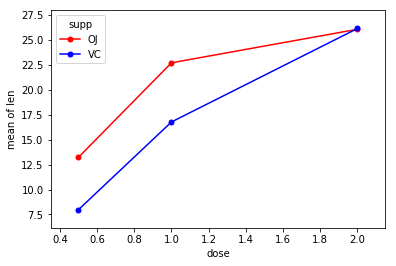

Multiple comparisons independent variable: supp
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper reject
------------------------------------------
  OJ     VC     -3.7   -7.567 0.167 False 
------------------------------------------

Multiple comparisons independent variable: dose
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.5    1.0     9.13    5.9018 12.3582  True 
 0.5    2.0    15.495  12.2668 18.7232  True 
 1.0    2.0    6.365    3.1368  9.5932  True 
---------------------------------------------



,Sum of Squares,df,F,Sig,ETA Square,Omega Square
supp,205.350,1,15.572,0.000,0.059,0.055
dose,2426.434,2,92.000,0.000,0.703,0.693
supp:dose,108.319,2,4.107,0.022,0.031,0.024
Residual,712.106,54,NaN,NaN,NaN,NaN


In [289]:
# Tooth growth (len) based on supplement type and dose.
# Dependent variable = len
# Independent variables (factors) = supp and dose
datafile = os.path.join(INPUT_DIR, 'ToothGrowth.csv')
data = pd.read_csv(datafile)

compute_two_way_anova(
    data,
    dependent_variable_name='len',
    independent_variable1_name='supp',
    independent_variable2_name='dose',
    alpha=0.05,
    display_chart=True,
)

### Interpretation of results

The 3 **rows supp, dose and supp:dose** inform us whether our independent variables (the "supplement" and "dose" rows) and their interaction (the "supp:dose" row) have a statistically significant effect on the dependent variable, "score". 

**It is important to first look at the "supp:dose" interaction as this will determine how to interpret the results.**

The "Sig" column shows that we have a statistically significant interaction at the p = 0.022 level (with alpha = 0.05). 

**Conclusion: Since H0 for the interaction effect was rejected, it can be concluded that the combination of type of supplement and dose level does affect tooth length.**

We could still report the results of "supplement" and "dose", but these need to be interpreted in the context of the interaction result (i.e **very cautiously**). 
When we have a statistically significant interaction, reporting the main effects can be misleading. Therefore, we need to report the simple main effects. This involves determining the mean difference in tooth length between supplement at each dosse level, as well as between dosse levels for each supplement.

We can see from the table above that with alpha = 0.05, there is a statistically significant difference in mean scores between OJ, and VC (p < .0005, which is smaller than alpha), as well as a statistically significant difference between dose levels 0.5, 1 and 2 (p < .0005, which is smaller than alpha).

### Chart

The chart lines cross each other. Since the interaction is significant, it is said to be a disordinal interaction and we should not interpret the main effects without considering the interaction effect.


### Notes
If the p-value is less than or equal to the alpha (p < .05), then we reject the null hypothesis, and we say the result is statistically significant. If the p-value is greater than alpha (p > .05), then we fail to reject the null hypothesis, and we say that the result is statistically nonsignificant.

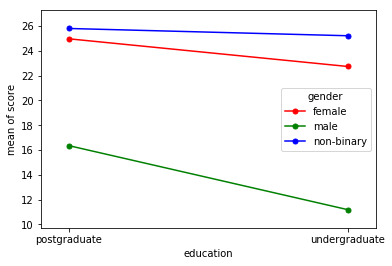

Multiple comparisons independent variable: gender
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1   group2   meandiff  lower    upper  reject
--------------------------------------------------
female    male    -10.0867 -13.9142 -6.2591  True 
female non-binary  1.6567  -2.1709   5.4842 False 
 male  non-binary 11.7433   7.9158  15.5709  True 
--------------------------------------------------

Multiple comparisons independent variable: education
    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
   group1        group2    meandiff  lower  upper  reject
---------------------------------------------------------
postgraduate undergraduate -2.6622  -6.0123 0.6879 False 
---------------------------------------------------------



,Sum of Squares,df,F,Sig,ETA Square,Omega Square
gender,2423.913,2,32.608,0.000,0.419,0.403
education,159.467,1,4.290,0.041,0.028,0.021
gender:education,80.731,2,1.086,0.342,0.014,0.001
Residual,3122.113,84,NaN,NaN,NaN,NaN


In [290]:
# Anxiety test.
# Dependent variable = len
# Independent variables (factors) = supp and dose
datafile = os.path.join(INPUT_DIR, 'anxietytest2.csv')
data = pd.read_csv(datafile)

compute_two_way_anova(
    data,
    dependent_variable_name='score',
    independent_variable1_name='gender',
    independent_variable2_name='education',
    alpha=0.05,
    display_chart=True,
    chart_color_list=['red', 'green', 'blue']
)

### Interpretation of results

The 3 **rows gender, education and gender:education** inform us whether our independent variables (the "gender" and "education" rows) and their interaction (the "gender:education" row) have a statistically significant effect on the dependent variable, "score". 

**It is important to first look at the "gender:education" interaction as this will determine how to interpret the results.**

The "Sig" column shows that we do NOT have a statistically significant interaction at the p = 0.342 level. 

**Conclusion: Since H0 for the interaction effect was NOT rejected, there is not enough evidence to conclude that the combination of gender and education level does affect the test score.**


We can continue to interprete the main effects of "gender" and "education" independently.

We can see from the table above that with alpha = 0.05, there is a statistically significant difference in mean scores between male, female and non-binary (p < .0005, which is smaller than alpha), as well as a statistically significant difference between education levels under-graduate and post-graduate (p = 0.041, which is smaller than alpha).

### Chart

Although, very close, this chart does NOT have an ordinal interaction between the 2 variables. The lines do not cross each other, but they are approximatively parallel.

This means that the main effects can be interpreted independently of each other because there is no significant interaction.

### ETA square

ETA square is analogous to R2
This is about effect size (weight of inpact), which can add up to 1.

Interesting for comparing influence of the factors 

### Multiple comparison table

**We check which comparison hypotheses were rejected to indentify which level pairs within one independent variable have a statistically significant difference.**